In [635]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [636]:
from data_loader_utility import get_dataloaders

In [637]:
train_loader, val_loader, test_loader = get_dataloaders()

In [638]:
imgs, labels = next(iter(train_loader))

(-0.5, 27.5, 27.5, -0.5)

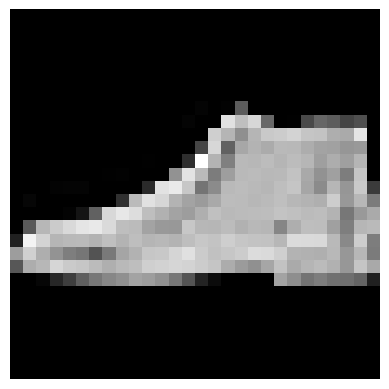

In [639]:
plt.imshow(imgs[0].reshape(28,28), cmap='gray')
plt.axis('off')

In [640]:
class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1)  # review wht the different channels are (andrew ng)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(28, 14, kernel_size=3, stride=1, padding=1)  # default padding is 0, so we need to specify 1 to get the dimensions we want
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # new convolutionl layer
        # self.conv3 = nn.Conv2d(14, 7, kernel_size=3, stride=1, padding=1)
        # self.act3 = nn.ReLU()
        # self.pool3 = nn.MaxPool2d(kernel_size=2)

        # batchnorm dded
        # self.bn1 = nn.BatchNorm2d()  # how does this value affect the later layers, accuracy, etc.?

        self.flat = nn.Flatten()
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x3388 and 343x343)
        self.fc4 = nn.Linear(14*7*7, 343)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(343, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        print(x.shape, 'original')
        x = self.act1(self.conv1(x))
        print(x.shape, 'after first conv')
        x = self.pool1(x)
        print(x.shape, 'after 1st maxpool')
        # x = self.drop1(x)
        # print(x.shape, 'after dropout')
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        print(x.shape, 'after 2nd conv')
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        print(x.shape, 'after 2nd maxpool')
        # new conv layer
        # x = self.act3(self.conv3(x))
        # print(x.shape, 'after 3rd conv')
        # x = self.pool3(x)
        # print(x.shape, 'after 2nd pool')
        # input 32x16x16, output 8192
        x = self.flat(x)
        x = torch.flatten(x)
        print(x.shape, 'after flattening')
        # input 8192, output 512
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # print(x.shape, 'after last dropout layer')
        # input 512, output 10
        x = self.fc5(x)
        print(x.shape, 'last shape after nn.Linear(343, 10)\n\n')
        return x


In [641]:
model = HomemadeCNN()
model.load_state_dict(torch.load('homemademodel.pth'))
model.eval()

HomemadeCNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=686, out_features=343, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=343, out_features=10, bias=True)
)

In [642]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [643]:
backward_hook = model.conv2.register_full_backward_hook(backward_hook)
forward_hook = model.conv2.register_forward_hook(forward_hook)

In [644]:
curr_img = imgs[10]
model(curr_img).sum().backward()

torch.Size([1, 28, 28]) original
torch.Size([28, 28, 28]) after first conv
torch.Size([28, 14, 14]) after 1st maxpool
Forward hook running...
Activations size: torch.Size([14, 14, 14])
torch.Size([14, 14, 14]) after 2nd conv
torch.Size([14, 7, 7]) after 2nd maxpool
torch.Size([686]) after flattening
torch.Size([10]) last shape after nn.Linear(343, 10)


Backward hook running...
Gradients size: torch.Size([14, 14, 14])


In [645]:
gradients[0].shape

torch.Size([14, 14, 14])

In [646]:
pooled_gradients = torch.mean(gradients[0], dim=[1,2])

In [647]:
import torch.nn.functional as F
# import matplotlib.pyplot as plt

# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=0).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
# plt.matshow(heatmap.detach())

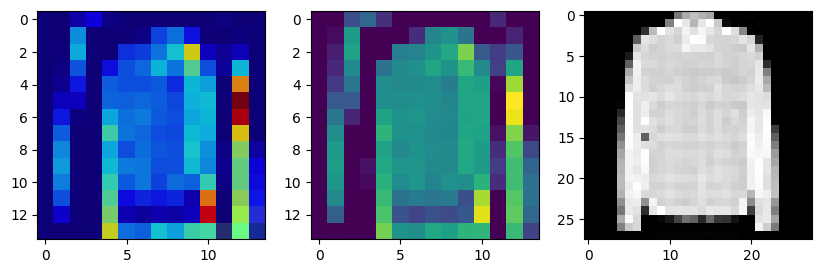

In [648]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

fig, ax = plt.subplots(1,3, figsize=(10,5))
ax = ax.flatten()

ax[0].imshow(to_pil_image(imgs[0]))

overlay = to_pil_image(heatmap.detach(), mode='F')

cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :]).astype(np.uint8)

ax[0].imshow(overlay, alpha=0.8, interpolation='nearest')
ax[1].imshow(heatmap.detach())
ax[2].imshow(curr_img.reshape(28,28), cmap='gray')
plt.show()